# See Through Gradients: Image Batch Recovery via GradInversion

This notebook shows an example for a **small batch image gradient inversion** as described in "See Through Gradients: Image Batch Recovery via GradInversion".

Paper URL: https://openaccess.thecvf.com/content/CVPR2021/html/Yin_See_Through_Gradients_Image_Batch_Recovery_via_GradInversion_CVPR_2021_paper.html

**This is only a partial re-implementation** of the original attack for which no code is available. If you have a better idea for these hyperparameters, don't hesitate to message us!

#### Abstract
Training deep neural networks requires gradient estimation from data batches to update parameters. Gradients per parameter are averaged over a set of data and this has been presumed to be safe for privacy-preserving training in joint, collaborative, and federated learning applications. Prior work only showed the possibility of recovering input data given gradients under very restrictive conditions - a single input point, or a network with no non-linearities, or a small 32x32 px input batch. Therefore, averaging gradients over larger batches was thought to be safe. In this work, we introduce GradInversion, using which input images from a larger batch (8 - 48 images) can also be recovered for large networks such as ResNets (50 layers), on complex datasets such as ImageNet (1000 classes, 224x224 px). We formulate an optimization task that converts random noise into natural images, matching gradients while regularizing image fidelity. We also propose an algorithm for target class label recovery given gradients. We further propose a group consistency regularization framework, where multiple agents starting from different random seeds work together to find an enhanced reconstruction of original data batch. We show that gradients encode a surprisingly large amount of information, such that all the individual images can be recovered with high fidelity via GradInversion, even for complex datasets, deep networks, and large batch sizes.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case=5_small_batch_imagenet", "attack=seethroughgradients"])
          
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case small_batch_imagenet with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [4]:
cfg.attack.optim.max_iterations = 40000

{'optimizer': 'adam', 'signed': False, 'step_size': 0.1, 'boxed': True, 'max_iterations': 20000, 'step_size_decay': 'cosine-decay', 'langevin_noise': 0.01, 'warmup': 50, 'grad_clip': None, 'callback': 1000}

In [7]:
cfg.case.user.user_idx = 0

cfg.case.user.num_data_points = 1

cfg.case.model = "resnet50" # also options are resnet50ssl or resnetmoco

# In this paper, there are no public buffers, but users send their batch norm statistic updates in combination 
# with their gradient updates to the server:
cfg.case.server.provide_public_buffers = False
cfg.case.user.provide_buffers = True

cfg.case.data.name = 'Birdsnap'
cfg.case.data.partition="random"

In [12]:
# cfg.attack.optim.langevin_noise = 1e-4
# cfg.attack.objective.scale = 1e-3

In [9]:
cfg.case.data.shape = [3, 250, 250]
cfg.case.data.normalize = False
cfg.case.data.augmentations_val = {}
cfg.case.data.augmentations_train = {}
cfg.case.data.name = 'LFWPeople'
cfg.case.data.partition = 'random'
cfg.case.data.path = '~/data/imagenet'
cfg.case.data.size = 13233
cfg.case.data.classes = 5749
cfg.case.data.normalize = False

In [10]:
cfg.case.data

{'db': {'name': None}, 'name': 'LFWPeople', 'modality': 'vision', 'task': 'classification', 'path': '~/data/imagenet', 'size': 13233, 'classes': 5749, 'shape': [3, 250, 250], 'normalize': False, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'augmentations_train': {}, 'augmentations_val': {}, 'default_clients': 50, 'partition': 'random', 'examples_from_split': 'validation', 'batch_size': 128, 'caching': False}

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [8]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1131)>

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [12]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 0 in model mode: training.


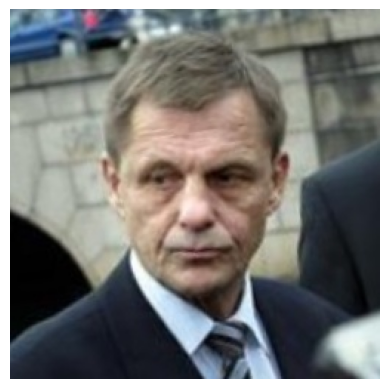

In [13]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [14]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [5211] through strategy yin.
| It: 1 | Rec. loss: 910024.5625 |  Task loss: 663.2791 | T: 6.57s
Recovery interrupted manually in iteration 237!
Optimal candidate solution with rec. loss 247941.3750 selected.


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [15]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Starting evaluations for attack effectiveness report...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


ConfigAttributeError: Key 'vocab_size' is not in struct
    full_key: case.data.vocab_size
    object_type=dict

And finally, we also plot the reconstructed data:

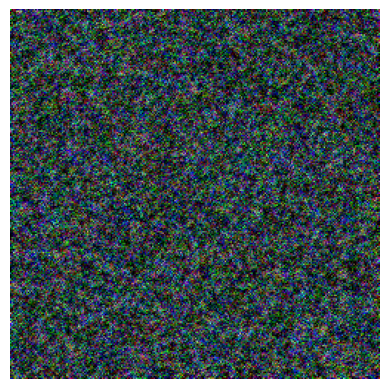

In [16]:
user.plot(reconstructed_user_data)

### Notes:
* Reconstructions with the Deep Inversion regularization take a while to compute.
* Likely settings for the Deep Inversion regularization are reverse-engineered from the related NVIDIA repository https://github.com/NVlabs/DeepInversion
* This is only a partial implementation of See Through Gradients: The Group Registration part is not included (and not entirely clear to me (Jonas Geiping) from the paper only)
* In some configurations of this attacks, the gradient reconstruction objective can actually be completely disabled and images can be recovered just as well based only on their batch norm statistics!